# Sadržaj

- [<i>StratifiedKFold</i>](#stratifiedkfold)
- [<i>cross_val_score</i>](#cross_val_score)
- [<i>GridSearchCV</i>](#search)
- [<i>RandomizedSearchCV</i>](#search)
- [<i>learning_curve</i>](#learning_curve)
- [<i>validation_curve</i>](#validation_curve)
- [<i>confusion_matrix</i>](#confusion_matrix)
- [<i>roc_curve</i>](#roc)
- [<i>roc_auc_score</i>](#roc)
- [<i>precision_recall_curve</i>](#precision_recall_curve)
- [<i>accuracy_score</i>](#score)
- [<i>precision_score</i>](#score)
- [<i>recall_score</i>](#score)
- [<i>f1_score</i>](#score)
- [<i>make_scorer</i>](#make_scorer)

## Korištenje klase <i><font color="red">StratifiedKFold</font></i> <a id="stratifiedkfold"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedKFold

<li>Priprema podataka i klasifikatora</li>

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

podaci_vino = datasets.load_wine()
podaci, oznake = podaci_vino.data, podaci_vino.target
podaci_tren, podaci_test, oznake_tren, oznake_test = train_test_split(podaci, oznake, test_size=0.2,
                                                                      stratify=oznake, random_state=1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

In [5]:
podaci_scale_tren = StandardScaler().fit_transform(podaci_tren)
podaci_lda_tren = LDA().fit_transform(podaci_scale_tren, oznake_tren)
svc = SVC(kernel='linear').fit(podaci_lda_tren, oznake_tren)

podaci_scale_test = StandardScaler().fit_transform(podaci_test)
podaci_lda_test = LDA().fit_transform(podaci_scale_test, oznake_test)

In [6]:
svc.score(podaci_lda_test, oznake_test)

1.0

In [7]:
from sklearn.metrics import classification_report

print(classification_report(oznake_test, svc.predict(podaci_lda_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      1.00      1.00        14
          2       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        36



<li>Odabir 5-struke unakrsne validacije</li>

In [8]:
stratifiedkfold = StratifiedKFold(n_splits=5).split(podaci_tren, oznake_tren)

In [9]:
rezultati = []
for (train, test) in stratifiedkfold:
    podaci_scale_tren = StandardScaler().fit_transform(podaci_tren[train])
    podaci_lda_tren = LDA().fit_transform(podaci_scale_tren, oznake_tren[train])
    svc = SVC(kernel='linear').fit(podaci_lda_tren, oznake_tren[train])
    podaci_scale_test = StandardScaler().fit_transform(podaci_tren[test])
    podaci_lda_test = LDA().fit_transform(podaci_scale_test, oznake_tren[test])
    rezultati.append(svc.score(podaci_lda_test, oznake_tren[test]))
print(f'Preciznost: {np.round(np.mean(rezultati), 3)} +/- {np.round(np.std(rezultati), 3)}')

Preciznost: 0.987 +/- 0.027


<li>Više o klasi <i>Pipeline</i> u zasebnom odjeljku</li>

In [10]:
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(), LDA(), SVC(kernel='linear'))

In [11]:
pipe_svc.fit(podaci_tren, oznake_tren)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [12]:
pipe_svc.score(podaci_test, oznake_test)

1.0

## Korištenje funkcije <i><font color="red">cross_val_score</font></i> <a id="cross_val_score"></a>

In [13]:
from sklearn.model_selection import cross_val_score

<li>Korištenje 2 jezgre procesora za 10-struku unakrsnu validaciju</li>

Preciznost: 0.977 +/- 0.035
[1.         0.93333333 1.         1.         1.         1.
 1.         0.92307692 1.         0.91666667]


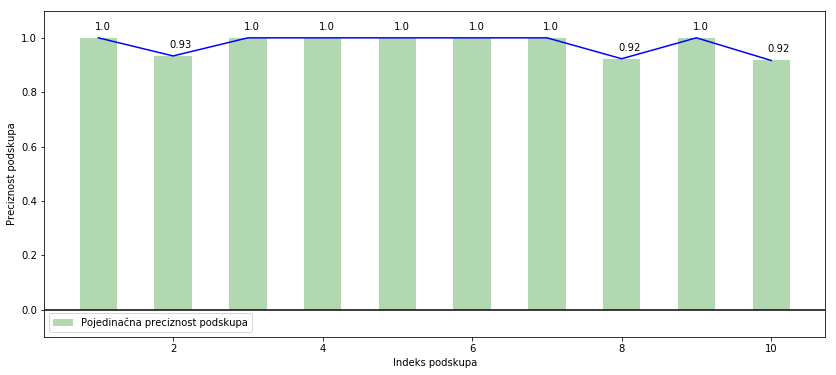

In [14]:
rezultati = cross_val_score(estimator=pipe_svc, X=podaci_tren, y=oznake_tren, cv=10, n_jobs=2)
print(f'Preciznost: {np.round(np.mean(rezultati), 3)} +/- {np.round(np.std(rezultati), 3)}')
print(rezultati)
plt.figure(figsize=(14,6))
plt.bar(range(1,11), rezultati, alpha=0.3, align='center', label='Pojedinačna preciznost podskupa', width=0.5, color='green')
for (i, rez) in enumerate(rezultati):
    plt.text(i + 0.95, rez + 0.03, str(np.round(rez, 2)))
plt.plot(range(1,11), rezultati, color='b')
plt.ylabel('Preciznost podskupa')
plt.axhline(y=0, color='black')
plt.ylim((-0.1, 1.1))
plt.xlabel('Indeks podskupa')
plt.legend(loc='lower left')
plt.show()

## Korištenje klasa <i><font color="red">GridSearchCV</font></i> i <i><font color="red">RandomizedSearchCV</font></i> <a id="search"></a>

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

<li>Testiranje svih kombinacija vrijednosti hiperparametara metode potpornih vektora (SVC)</li>

In [16]:
raspon = [0.01, 0.1, 1.0, 10.0, 100.0]
mogucnosti = [{'svc__C': raspon, 'svc__kernel': ['linear']},
              {'svc__C': raspon, 'svc__gamma': raspon, 'svc__kernel': ['rbf']},
              {'svc__C': raspon, 'svc__gamma': raspon, 'svc__coef0': raspon, 'svc__kernel': ['sigmoid']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=mogucnosti, scoring='accuracy',
                  cv=10, n_jobs=-1, verbose=True, return_train_score=True)

In [17]:
gs.fit(podaci_tren, oznake_tren)

Fitting 10 folds for each of 155 candidates, totalling 1550 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1550 out of 1550 | elapsed:    5.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('svc'...
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__kernel': ['linear']}, {'svc__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__gamma': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__kernel': ['rbf']}, {'svc__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__gamma': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__coef0': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__kernel': ['sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [18]:
gs.best_params_

{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

In [19]:
np.round(gs.best_score_, 3)

0.986

In [20]:
est = gs.best_estimator_

In [21]:
est.score(podaci_test, oznake_test)

1.0

In [22]:
print(classification_report(oznake_test, est.predict(podaci_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      1.00      1.00        14
          2       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        36



In [23]:
df = pd.DataFrame(gs.cv_results_)
df.head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__C,param_svc__coef0,param_svc__gamma,param_svc__kernel,params,rank_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.034803,0.000598,0.971831,1.000000,0.01,NaN,NaN,linear,"{'svc__C': 0.01, 'svc__kernel': 'linear'}",19,...,0.846154,1.0,1.0,1.000000,0.916667,1.0,0.017041,0.000489,0.049292,0.000000
1,0.006981,0.000498,0.978873,0.998443,0.1,NaN,NaN,linear,"{'svc__C': 0.1, 'svc__kernel': 'linear'}",2,...,0.923077,1.0,1.0,0.992308,0.916667,1.0,0.002442,0.000669,0.033937,0.003114
2,0.008477,0.000199,0.978873,0.998443,1,NaN,NaN,linear,"{'svc__C': 1.0, 'svc__kernel': 'linear'}",2,...,0.923077,1.0,1.0,0.992308,0.916667,1.0,0.001022,0.000399,0.033937,0.003114
3,0.006782,0.000798,0.978873,1.000000,10,NaN,NaN,linear,"{'svc__C': 10.0, 'svc__kernel': 'linear'}",2,...,0.923077,1.0,1.0,1.000000,0.916667,1.0,0.001596,0.000399,0.033937,0.000000
4,0.003291,0.000000,0.978873,1.000000,100,NaN,NaN,linear,"{'svc__C': 100.0, 'svc__kernel': 'linear'}",2,...,0.923077,1.0,1.0,1.000000,0.916667,1.0,0.000779,0.000000,0.033937,0.000000


In [24]:
mogucnosti = {'svc__C': np.arange(0.01, 100, 0.01), 'svc__gamma': np.arange(0.01, 100, 0.01), 'svc__kernel': ['rbf']}
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=mogucnosti, scoring='accuracy',
                        n_iter=30, cv=10, n_jobs=-1, verbose=True)
rs.fit(podaci_tren, oznake_tren)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('svc'...
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'svc__C': array([1.000e-02, 2.000e-02, ..., 9.998e+01, 9.999e+01]), 'svc__gamma': array([1.000e-02, 2.000e-02, ..., 9.998e+01, 9.999e+01]), 'svc__kernel': ['rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=True)

In [25]:
rs.best_params_

{'svc__C': 61.47, 'svc__gamma': 2.4499999999999997, 'svc__kernel': 'rbf'}

In [26]:
np.round(rs.best_score_, 3)

0.951

In [27]:
est = rs.best_estimator_

In [28]:
est.score(podaci_test, oznake_test)

1.0

In [29]:
print(classification_report(oznake_test, est.predict(podaci_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      1.00      1.00        14
          2       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        36



<li>Izvođenje 5x2 ugniježđene unakrsne validacije za selekciju modela</li>

In [30]:
raspon = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
mogucnosti = [{'svc__C': raspon, 'svc__kernel': ['linear']},
              {'svc__C': raspon, 'svc__gamma': raspon, 'svc__kernel': ['rbf']},
              {'svc__C': raspon, 'svc__gamma': raspon, 'svc__coef0': raspon, 'svc__kernel': ['sigmoid']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=mogucnosti, scoring='accuracy',
                  cv=2, n_jobs=-1, verbose=True, return_train_score=True)

rezultati = cross_val_score(estimator=gs, X=podaci, y=oznake, cv=5, n_jobs=-1)
print(f'Preciznost: {np.round(np.mean(rezultati), 3)} +/- {np.round(np.std(rezultati), 3)}')

Preciznost: 0.972 +/- 0.018


## Korištenje funkcije <i><font color="red">learning_curve</font></i> <a id="learning_curve"></a>

In [31]:
from sklearn.model_selection import learning_curve

<li>Generiranje krivulja učenja za 20 veličina podataka za treniranje</li>

In [32]:
velicine_skupa, rez_tren, rez_test = learning_curve(estimator=pipe_svc, X=podaci_tren, y=oznake_tren,
                                                        train_sizes=np.linspace(0.1, 1.0, 15), cv=10, n_jobs=-1)
tren_sred = np.mean(rez_tren, axis=1)
tren_sdev = np.std(rez_tren, axis=1)
test_sred = np.mean(rez_test, axis=1)
test_sdev = np.std(rez_test, axis=1)

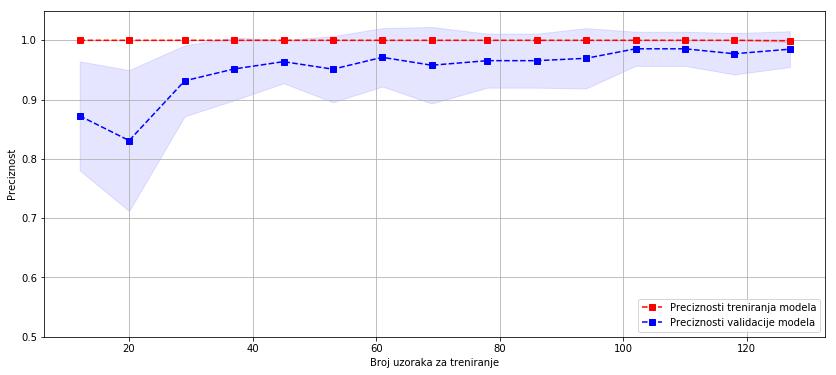

In [33]:
plt.figure(figsize=(14,6))
plt.grid()
plt.plot(velicine_skupa, tren_sred, color='red', linestyle='--', marker='s', label='Preciznosti treniranja modela')
plt.plot(velicine_skupa, test_sred, color='blue', linestyle='--', marker='s', label='Preciznosti validacije modela')
plt.fill_between(velicine_skupa, tren_sred - tren_sdev, tren_sred + tren_sdev, alpha=0.1, color='red')
plt.fill_between(velicine_skupa, test_sred - test_sdev, test_sred + test_sdev, alpha=0.1, color='blue')
plt.xlabel('Broj uzoraka za treniranje')
plt.ylabel('Preciznost')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.show()

## Korištenje funkcije <i><font color="red">validation_curve</font></i> <a id="validation_curve"></a>

In [34]:
from sklearn.model_selection import validation_curve

<li>Generiranje krivulja validacija za različite vrijednosti varijable <i>C</i> metode potpornih vektora</li>

In [35]:
rez_tren, rez_test = validation_curve(estimator=pipe_svc, X=podaci_tren, y=oznake_tren, cv=10, n_jobs=-1,
                                                      param_name='svc__C', param_range=raspon)
tren_sred = np.mean(rez_tren, axis=1)
tren_sdev = np.std(rez_tren, axis=1)
test_sred = np.mean(rez_test, axis=1)
test_sdev = np.std(rez_test, axis=1)

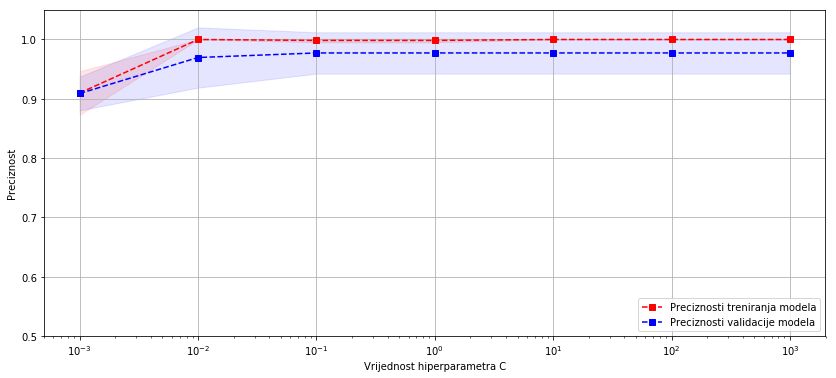

In [36]:
plt.figure(figsize=(14,6))
plt.grid()
plt.plot(raspon, tren_sred, color='red', linestyle='--', marker='s', label='Preciznosti treniranja modela')
plt.plot(raspon, test_sred, color='blue', linestyle='--', marker='s', label='Preciznosti validacije modela')
plt.fill_between(raspon, tren_sred - tren_sdev, tren_sred + tren_sdev, alpha=0.1, color='red')
plt.fill_between(raspon, test_sred - test_sdev, test_sred + test_sdev, alpha=0.1, color='blue')
plt.xlabel('Vrijednost hiperparametra C')
plt.ylabel('Preciznost')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.xscale('log')
plt.show()

## Korištenje klase <i><font color="red">Pipeline</font></i> <a id="pipeline"></a>

In [37]:
from sklearn.pipeline import make_pipeline

<li>Ulančavanje klasa <i>StandardScaler</i>, <i>PCA</i> i <i>LogisticRegression</i> u jedan meta-estimator</li>

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

podaci_rak = datasets.load_breast_cancer()
podaci, oznake = podaci_rak.data, podaci_rak.target
podaci_tren, podaci_test, oznake_tren, oznake_test = train_test_split(podaci, oznake, test_size=0.2,
                                                                      stratify=oznake, random_state=1)
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=5), LogisticRegression(penalty='l2', C=0.01))

In [39]:
pipe_lr.fit(podaci_tren, oznake_tren)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_int...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [40]:
pipe_lr.score(podaci_test, oznake_test)

0.9736842105263158

## Korištenje funkcije <i><font color="red">confusion_matrix</font></i> <a id="confusion_matrix"></a>

In [41]:
from sklearn.metrics import confusion_matrix

<li>Određivanje matrice grešaka za binarni problem klasifikacije</li>

In [42]:
confmat = confusion_matrix(y_true=oznake_test, y_pred=pipe_lr.predict(podaci_test))
print(confmat)

[[40  2]
 [ 1 71]]


In [43]:
con_dict = {"TN":confmat[0,0], "FP":confmat[0,1], "FN":confmat[1,0], "TP":confmat[1,1]}
print(con_dict)

{'TN': 40, 'FP': 2, 'FN': 1, 'TP': 71}


## Korištenje funkcija <i><font color="red">roc_curve</font></i> i <i><font color="red">roc_auc_score</font></i> <a id="roc"></a>

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

<li>Kreiranje ROC krivulja za 3 različita modela i izračun ROC AUC vrijednosti za svaki</li>

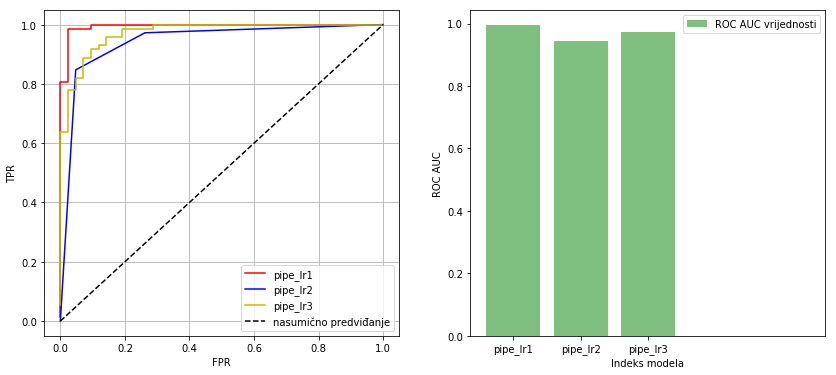

In [46]:
from sklearn.ensemble import RandomForestClassifier

vjerojatnosti = []
roc_score = []

pipe_lr1 = make_pipeline(StandardScaler(), PCA(n_components=5), LogisticRegression(penalty='l2', C=0.01))
vjerojatnosti.append(pipe_lr1.fit(podaci_tren, oznake_tren).predict_proba(podaci_test))

pipe_lr2 = make_pipeline(PCA(n_components=3), RandomForestClassifier(n_estimators=2))
vjerojatnosti.append(pipe_lr2.fit(podaci_tren, oznake_tren).predict_proba(podaci_test))

pipe_lr3 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=0.00575))
vjerojatnosti.append(pipe_lr3.fit(podaci_tren, oznake_tren).predict_proba(podaci_test))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].grid()
for c, i, v in zip(['r', 'b', 'y'], range(1,4), vjerojatnosti):
    fpr, tpr, thresholds = roc_curve(oznake_test, v[:, 1], pos_label=1)
    ax[0].plot(fpr, tpr, label=f'pipe_lr{i}', color=c)
    roc_score.append(roc_auc_score(oznake_test, v[:, 1]))

ax[0].plot([0, 1], [0, 1], linestyle='--', color='black', label='nasumično predviđanje')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].legend(loc='lower right')
ax[1].bar(range(1,6), np.concatenate((roc_score, np.zeros(2))), color='g', alpha=0.5,
          align='center', label='ROC AUC vrijednosti')
ax[1].set_xlabel('Indeks modela')
ax[1].set_xticks((1,2,3))
ax[1].set_xticklabels([f'pipe_lr{i}' for i in (1,2,3)])
ax[1].set_ylabel('ROC AUC')
ax[1].legend(loc='best')
plt.show()

## Korištenje funkcije <i><font color="red">precision_recall_curve</font></i> <a id="precision_recall_curve"></a>

In [47]:
from sklearn.metrics import precision_recall_curve

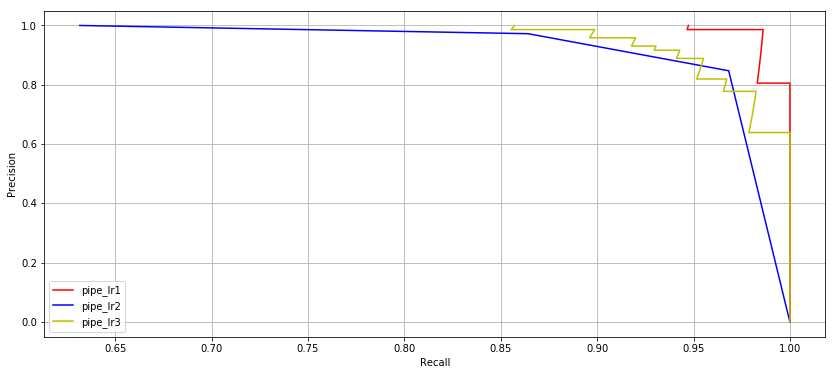

In [48]:
plt.figure(figsize=(14,6))
plt.grid()
for c, i, v in zip(['r', 'b', 'y'], range(1,4), vjerojatnosti):
    pre, rec, thresholds = precision_recall_curve(oznake_test, v[:, 1], pos_label=1)
    plt.plot(pre, rec, label=f'pipe_lr{i}', color=c)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

## Korištenje funkcija <i><font color="red">accuracy_score</font></i>, <i><font color="red">precision_score</font></i>, <i><font color="red">recall_score</font></i> i <i><font color="red">f1_score</font></i> <a id="score"></a>

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

podaci_pred = pipe_lr.predict(podaci_test)

<li>accuracy score</li>

In [56]:
print(f'Accuracy: {accuracy_score(y_true=oznake_test, y_pred=podaci_pred)}')

Accuracy: 0.9736842105263158


<li>precision score</li>

In [57]:
print(f'Precision: {precision_score(y_true=oznake_test, y_pred=podaci_pred)}')

Precision: 0.9726027397260274


<li>recall score</li>

In [58]:
print(f'Recall: {recall_score(y_true=oznake_test, y_pred=podaci_pred)}')

Recall: 0.9861111111111112


<li>f1 score</li>

In [59]:
print(f'f1: {f1_score(y_true=oznake_test, y_pred=podaci_pred)}')

f1: 0.9793103448275863


In [60]:
from sklearn.metrics import precision_recall_fscore_support

In [73]:
print('-podudaranje 2. stupca s rezultatima prijašnjih funkcija za pozitivnu klasu (klasu 1)-')
rez = precision_recall_fscore_support(y_true=oznake_test, y_pred=podaci_pred)
df = pd.DataFrame({"Precision":rez[0], "Recall":rez[1], "f1":rez[2], "Broj uzoraka":rez[3]})
df

-podudaranje 2. stupca s rezultatima prijašnjih funkcija za pozitivnu klasu (klasu 1)-


,Broj uzoraka,Precision,Recall,f1
0,42,0.975610,0.952381,0.963855
1,72,0.972603,0.986111,0.979310


## Korištenje funkcije <i><font color="red">make_scorer</font></i> <a id="make_scorer"></a>

In [77]:
from sklearn.metrics import make_scorer

<li>Odabir f1 metrike za GridSearchCV</li>

In [79]:
scorer = make_scorer(f1_score, pos_label=1)

In [80]:
raspon = [0.01, 0.1, 1.0, 10.0, 100.0]
mogucnosti = [{'svc__C': raspon, 'svc__kernel': ['linear']},
              {'svc__C': raspon, 'svc__gamma': raspon, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=mogucnosti, scoring=scorer,
                  cv=10, n_jobs=-1, verbose=True, return_train_score=True, )

In [81]:
gs.fit(podaci_tren, oznake_tren)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('svc'...
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__kernel': ['linear']}, {'svc__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__gamma': [0.01, 0.1, 1.0, 10.0, 100.0], 'svc__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, pos_label=1), verbose=True)

In [84]:
print(f'f1: {np.round(gs.score(podaci_test, oznake_test), 3)}')

f1: 0.973
